In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dash
from dash import html, dcc, dash_table, Input, Output
import plotly.express as px

In [3]:
file = "sales situation on Xiaohongshu.csv"
df = pd.read_csv(file)
df.head()

,revenue,gender,age,engaged_last_30,lifecycle,days_since_last_order,previous_order_amount,3rd_party_stores
0,72.98,1.0,59.0,0.0,B,4.26,2343.870,0
1,200.99,1.0,51.0,0.0,A,0.94,8539.872,0
2,69.98,1.0,79.0,0.0,C,4.29,1687.646,1
3,649.99,NaN,NaN,NaN,C,14.90,3498.846,0
4,83.59,NaN,NaN,NaN,C,21.13,3968.490,4


Before we dive into the analysis, let’s check for missing values.

In [4]:
df.isnull().sum()

revenue                        0
gender                     11729
age                        12736
engaged_last_30            11729
lifecycle                      0
 days_since_last_order         0
previous_order_amount          0
3rd_party_stores               0
dtype: int64

It turns out there are quite a lot missing values in age, gender and engaged_last_30. I'm considering filling in some of these gaps—like using the median for age and the mode for gender. For engaged_last_30, I assume missing means not engaged so I will fill with 0. 

Since the amount of missing data is pretty significant, I think just dropping those rows or leaving them empty isn't the best approach.

In [5]:
df['age'] = df['age'].fillna(df['age'].median())

df['gender'] = df['gender'].fillna(df['gender'].mode()[0])

df['engaged_last_30'] = df['engaged_last_30'].fillna(0)

df.isnull().sum()

revenue                    0
gender                     0
age                        0
engaged_last_30            0
lifecycle                  0
 days_since_last_order     0
previous_order_amount      0
3rd_party_stores           0
dtype: int64

Now, let's analyze user purchasing behavior and summarize key statistics.

In [6]:
df.describe()

,revenue,gender,age,engaged_last_30,days_since_last_order,previous_order_amount,3rd_party_stores
count,29452.000000,29452.000000,29452.000000,29452.000000,29452.000000,29452.000000,29452.000000
mean,398.288037,0.970359,60.225553,0.043970,7.711348,2348.904830,2.286059
std,960.251728,0.169599,11.168826,0.205032,6.489289,2379.774213,3.538219
min,0.020000,0.000000,18.000000,0.000000,0.130000,0.000000,0.000000
25%,74.970000,1.000000,58.000000,0.000000,2.190000,773.506250,0.000000
50%,175.980000,1.000000,60.000000,0.000000,5.970000,1655.980000,0.000000
75%,499.990000,1.000000,62.000000,0.000000,11.740000,3096.766500,3.000000
max,103466.100000,1.000000,99.000000,1.000000,23.710000,11597.900000,10.000000


In order to explore user purchasing trends, gender-based spending differences, and lifecycle-based spending behavior, I will draw different graph below.

#1 Revenue Distribution (Histogram)
It gives us a clear picture of how much people are spending.

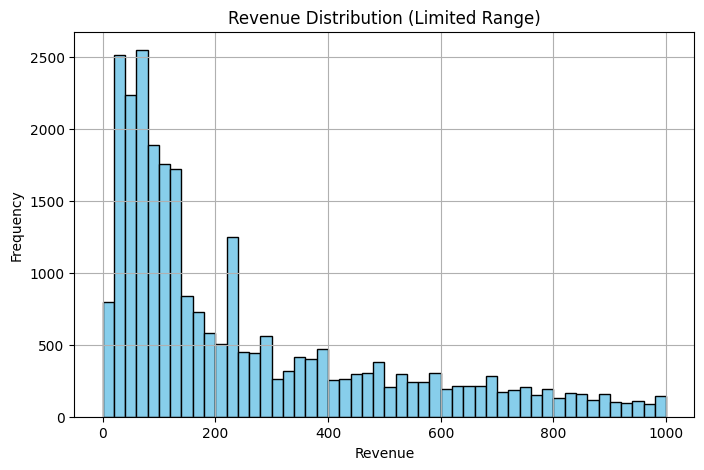

In [7]:
plt.figure(figsize=(8,5))
df[df['revenue'] < 1000]['revenue'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Revenue Distribution (Limited Range)')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

This histogram shows how users are spending on Xiaohongshu, focusing on purchases under 1000. Looking at the chart, we can see it is a right-skewed distribution. As spending goes up, the frequency of transactions drops, suggesting that the majority of users prefer to spend smaller amounts. Besides, the highest point on the graph is close to 0, which indicates that many users are making small purchases. The next peak around 200 might reflect a pricing strategy or a typical behavior among users.

#2 User Engagement vs. Revenue (Box Plot)  
We can see whether users who are more engaged actually tend to spend more.

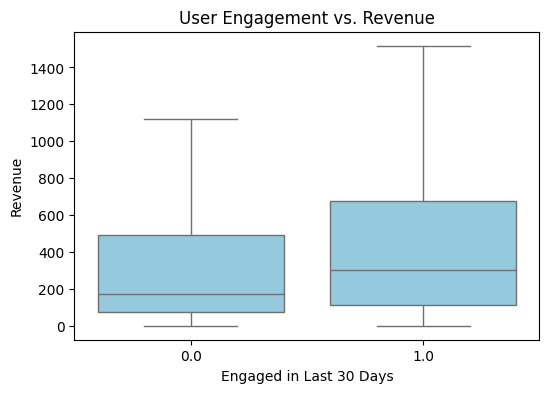

In [8]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['engaged_last_30'], y=df['revenue'], color='skyblue', showfliers=False)
plt.title('User Engagement vs. Revenue')
plt.xlabel('Engaged in Last 30 Days')
plt.ylabel('Revenue')
plt.show()

This box plot visualizes the relationship between user engagement and revenue. The two categories (0.0 and 1.0) on the x-axis represent users who did not engage in discussions or photo-sharing in the last 30 days and users who did engage in discussions or photo-sharing in the last 30 days. Based on the graph above, we can see the median revenue for engaged users is higher than for non-engaged users, meaning that users who actively engage in the community tend to spend more than those who do not participate. Additionally, the whiskers extend further up for engaged users, suggesting that the highest-spending users are more likely to be engaged.

#3 Gender-Based Purchasing Trends (Box Plot)
It compares spending differences between male and female users.

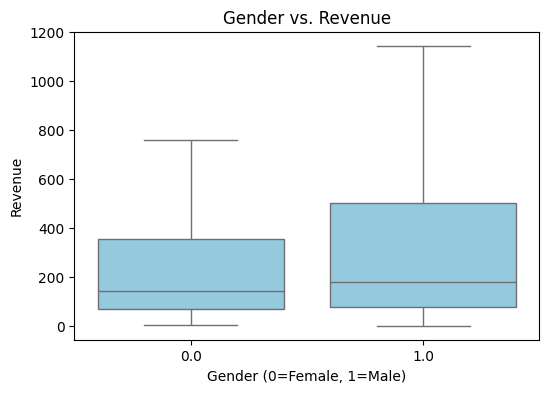

In [9]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['gender'], y=df['revenue'], color='skyblue', showfliers=False)
plt.title('Gender vs. Revenue')
plt.xlabel('Gender (0=Female, 1=Male)')
plt.ylabel('Revenue')
plt.show()

The box plot shows how much male and female users spend on Xiaohongshu. We can see that they spend similarly on average, but male spending is more varied with a wider distribution and higher outliers. Female users exhibit a tighter spending range, indicating more consistent spending patterns, meaning targeted promotions could effectively increase their spending.

#4 Lifecycle vs. Spending Patterns (Bar Chart)
It helps determine if longer-registered users actually spend more money. Bar chart is a great way to visualize the total revenue for each category in the lifecycle.

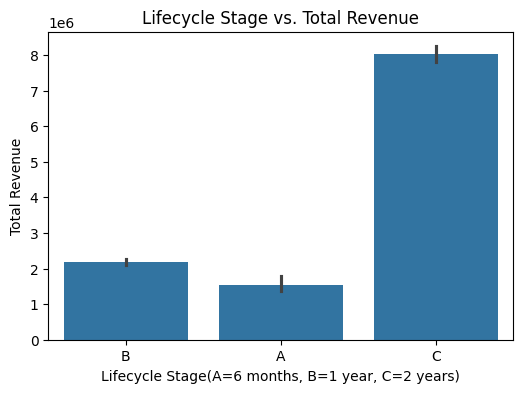

In [10]:
plt.figure(figsize=(6,4))
sns.barplot(x=df['lifecycle'], y=df['revenue'], estimator=sum)
plt.title('Lifecycle Stage vs. Total Revenue')
plt.xlabel('Lifecycle Stage(A=6 months, B=1 year, C=2 years)')
plt.ylabel('Total Revenue')
plt.show()

The bar chart shows that users registered for 2 years generate the highest total revenue, indicating longer-term users tend to spend more. In contrast, users registered for 6 months contribute the least revenue, suggesting new users take time to develop purchasing habits.

#5 Average Revenue by Gender (Dash)
Using Dash allows real-time exploration of how average revenue varies by gender, providing a more interactive approach compared to static visualizations.

In [5]:
app = dash.Dash(__name__)  

df = pd.read_csv("sales situation on Xiaohongshu.csv")
df = df.sample(n=1000)
df.columns = df.columns.str.lower()

app.layout = html.Div([
    html.H1("Xiaohongshu User Analytics", style={'textAlign': 'center'}),

    dcc.RadioItems(
        options=['revenue', 'previous_order_amount'],
        value='revenue',
        inline=True,
        id='data-selector'
    ),

    html.Div([
        dash_table.DataTable(data=df.to_dict('records'), page_size=10, style_table={'overflowX': 'auto'}),
        dcc.Graph(id='histo-chart')
    ])
])

@app.callback(
    Output('histo-chart', 'figure'),
    Input('data-selector', 'value')
)
def update_graph(col_chosen):
    fig = px.histogram(df, x='gender', y=col_chosen, histfunc='avg', title=f'Average {col_chosen} by Gender')
    return fig

if __name__ == '__main__':
    app.run_server(mode='external', debug=True)

To make the project easier to visualize and analyze, I pulled a sample of 1000 rows for better performance. I made sure to change all the column names to lowercase and removed any missing values to keep things accurate. I also set a limit on revenue at 1000 to reduce the impact of outliers. At first look, it seems like male and female users spend similarly, with no major differences. However, since it's interactive, you can use filters like engagement status or lifecycle stage. This way, you’ll discover that engaged users actually show a larger spending gap between the genders.